在这一章中，我主要实现了第四章策略迭代算法和值迭代算法。

In [5]:
# Step1：导入所有必要的库
import time
from typing import Optional, Union, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import random
from IPython.display import display, clear_output

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
np.random.seed(1)

由于在网格世界中，我们需要频繁检查智能体是否碰到了障碍物，使用`np.array_equal`比较数组内容。

In [6]:
# Step2：辅助函数
def arr_in_list(array, _list):
    """
    检查一个numpy数组是否在另一个列表中
    """
    for element in _list:
        if np.array_equal(element, array):
            return True
    return False

In [7]:
# Step3：可视化工具
class Render:
    """
    网格世界可视化工具类
    """
    def __init__(self, target: Union[list, tuple, np.ndarray], 
                 forbidden: Union[list, tuple, np.ndarray], size: int = 5):
        self.agent = None
        self.target = np.array(target)
        self.forbidden = [np.array(fob) for fob in forbidden]
        self.size = size
        self.fig = None
        self.ax = None
        self.trajectory = []
        self.reset_canvas()

    def create_canvas(self, figsize: Tuple[int, int] = None) -> None:
        if self.fig is not None:
            plt.close(self.fig)
        if figsize is None:
            figsize = (10, 10)
        self.fig, self.ax = plt.subplots(figsize=figsize, dpi=self.size * 20)
        if self.agent is not None:
            self.agent.remove()
        self.agent = patches.Arrow(-10, -10, 0.4, 0, color='red', width=0.5)

    def init_grid(self) -> None:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        
        self.ax.xaxis.set_ticks_position('top')
        self.ax.invert_yaxis()
        self.ax.xaxis.set_ticks(range(0, self.size + 1))
        self.ax.yaxis.set_ticks(range(0, self.size + 1))
        self.ax.grid(True, linestyle="-", color="gray", linewidth="1", axis='both')
        self.ax.tick_params(bottom=False, left=False, right=False, top=False, 
                           labelbottom=False, labelleft=False, labeltop=False)

        for y in range(self.size):
            self.write_word(pos=(-0.6, y), word=str(y + 1), size_discount=0.8)
            self.write_word(pos=(y, -0.6), word=str(y + 1), size_discount=0.8)
        
        self.ax.add_patch(self.agent)

    def reset_canvas(self, clear_trajectory: bool = True, figsize: Tuple[int, int] = None) -> None:
        self.create_canvas(figsize)
        self.init_grid()
        for pos in self.forbidden:
            self.fill_block(pos=pos)
        self.fill_block(pos=self.target, color='darkturquoise')
        if clear_trajectory:
            self.trajectory = []

    def fill_block(self, pos: Union[list, tuple, np.ndarray], color: str = '#EDB120', 
                   width: float = 1.0, height: float = 1.0) -> patches.Rectangle:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        return self.ax.add_patch(
            patches.Rectangle((pos[0], pos[1]), width=width, height=height,
                            facecolor=color, fill=True, alpha=0.90)
        )

    def draw_random_line(self, pos1: Union[list, tuple, np.ndarray], pos2: Union[list, tuple, np.ndarray]) -> None:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        offset1 = np.random.uniform(low=-0.05, high=0.05, size=1)
        offset2 = np.random.uniform(low=-0.05, high=0.05, size=1)
        x = [pos1[0] + 0.5, pos2[0] + 0.5]
        y = [pos1[1] + 0.5, pos2[1] + 0.5]
        if pos1[0] == pos2[0]:
            x = [x[0] + offset1, x[1] + offset2]
        else:
            y = [y[0] + offset1, y[1] + offset2]
        self.ax.plot(x, y, color='g', scalex=False, scaley=False)

    def draw_action(self, pos: Union[list, tuple, np.ndarray], toward: Union[list, tuple, np.ndarray],
                    color: str = 'green', radius: float = 0.10) -> None:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        if not np.array_equal(np.array(toward), np.array([0, 0])):
            self.ax.add_patch(
                patches.Arrow(pos[0] + 0.5, pos[1] + 0.5, dx=toward[0], dy=toward[1], 
                            color=color, width=0.05 + 0.05 * np.linalg.norm(np.array(toward) / 0.5),
                            linewidth=0.5)
            )
        else:
            self.draw_circle(pos=tuple(pos), color='white', radius=radius, fill=False)

    def draw_circle(self, pos: Union[list, tuple, np.ndarray], radius: float, 
                    color: str = 'green', fill: bool = True) -> patches.Circle:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        return self.ax.add_patch(
            patches.Circle((pos[0] + 0.5, pos[1] + 0.5), radius=radius,
                         facecolor=color, edgecolor='green', linewidth=2, fill=fill)
        )

    def write_word(self, pos: Union[list, np.ndarray, tuple], word: str, color: str = 'black', 
                   y_offset: float = 0, size_discount: float = 1.0) -> None:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        font_size = size_discount * (30 - 2 * self.size)
        self.ax.text(pos[0] + 0.5, pos[1] + 0.5 + y_offset, word, 
                    size=font_size, ha='center', va='center', color=color)

    def upgrade_agent(self, pos: Union[list, np.ndarray, tuple], action: Union[list, np.ndarray, tuple],
                      next_pos: Union[list, np.ndarray, tuple]) -> None:
        self.trajectory.append([tuple(pos), action, tuple(next_pos)])

    def show_frame(self, t: float = 0.2, close_after: bool = False) -> None:
        if self.fig is None:
            raise ValueError("请先调用create_canvas()创建画布")
        # 在Jupyter中显示
        clear_output(wait=True)
        display(self.fig)
        if close_after:
            plt.close(self.fig)
            self.fig = None
            self.ax = None

    def visualize_state_values(self, state_values: np.ndarray, y_offset: float = 0.2) -> None:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        for state in range(self.size * self.size):
            x = state // self.size
            y = state % self.size
            value_text = f"{state_values[state]:.1f}"
            self.write_word(pos=(x, y), word=value_text, color='black', 
                           y_offset=y_offset, size_discount=0.7)
            
    def visualize_policy(self, policy: np.ndarray, action_to_direction: dict) -> None:
        if self.ax is None:
            raise ValueError("请先调用create_canvas()创建画布")
        for state in range(self.size * self.size):
            x = state // self.size
            y = state % self.size
            for action in range(len(action_to_direction)):
                prob = policy[state, action]
                if prob > 0.0:
                    direction = action_to_direction[action] * 0.4 * prob
                    self.draw_action(pos=[x, y], toward=direction, color='green', radius=0.03 + 0.07 * prob)


In [11]:

# Step4：网格世界环境
class GridWorldEnv:
    """
    强化学习网格世界环境
    """
    def __init__(self, size: int, start: Union[list, tuple, np.ndarray],
                 target: Union[list, tuple, np.ndarray], forbidden: Union[list, tuple, np.ndarray],
                 render_mode: Optional[str] = None, reward_list: Optional[List[float]] = None,
                 max_steps: int = 100000):
        
        if size <= 0 or not isinstance(size, int):
            raise ValueError("网格大小必须为正整数")
            
        def validate_position(pos, name):
            if (pos[0] < 0 or pos[0] >= size or pos[1] < 0 or pos[1] >= size):
                raise ValueError(f"{name}位置必须在网格范围内(0-{size-1})")
            return np.array(pos, dtype=int)
        
        self.time_steps = 0
        self.size = size
        self.render_mode = render_mode
        self.max_steps = max_steps
        self.agent_location = validate_position(start, "起始点")
        self.target_location = validate_position(target, "目标点")
        
        self.forbidden_location = []
        for fob in forbidden:
            fob_pos = validate_position(fob, "障碍物")
            if np.array_equal(fob_pos, self.agent_location) or np.array_equal(fob_pos, self.target_location):
                raise ValueError("障碍物不能位于起点或目标点上")
            self.forbidden_location.append(fob_pos)

        self.render_ = Render(target=target, forbidden=forbidden, size=size)
        
        # 移除gym依赖，手动定义动作空间和观测空间
        self.action_space_size = 5  # 5个动作：停留、上、右、下、左
        
        
        # 动作到方向向量的映射（使用行列坐标）
        self.action_to_direction = {
            0: np.array([0, 0]),   # 停留
            1: np.array([-1, 0]),  # 上（row减小，col不变）
            2: np.array([0, 1]),   # 右（row不变，col增大）
            3: np.array([1, 0]),   # 下（row增大，col不变）
            4: np.array([0, -1]),  # 左（row不变，col减小）
}

        self.reward_list = reward_list if reward_list is not None else [0, 1, -10, -1]

        self.Rsa = None
        self.Psa = None
        self.psa_rsa_init()

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        if options is not None and "start" in options:
            start_pos = self.state2pos(options['start'])
            start_pos = np.array(start_pos, dtype=int)
            if (start_pos[0] < 0 or start_pos[0] >= self.size or 
                start_pos[1] < 0 or start_pos[1] >= self.size):
                raise ValueError(f"新起点必须在网格范围内(0-{self.size-1})")
            self.agent_location = start_pos
        else:
            self.agent_location = np.array([0, 0])
            
        self.time_steps = 0
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action: int):
        if action < 0 or action >= self.action_space_size:
            raise ValueError(f"动作必须在0-{self.action_space_size-1}范围内")
            
        current_state = self.pos2state(self.agent_location)
        reward_index = self.Rsa[current_state, action].tolist().index(1)
        reward = self.reward_list[reward_index]

        direction = self.action_to_direction[action]
        new_pos = self.agent_location + direction
        self.render_.upgrade_agent(self.agent_location, direction, new_pos)
        self.agent_location = np.clip(new_pos, 0, self.size - 1)

        self.time_steps += 1
        terminated = np.array_equal(self.agent_location, self.target_location)
        truncated = self.time_steps >= self.max_steps

        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

    def render(self) -> None:
        if self.render_mode == "video":
            self.render_.save_video('image/' + str(time.time()))
        self.render_.show_frame(100)

    def _get_obs(self):
        return {"agent": self.agent_location, "target": self.target_location, "barrier": self.forbidden_location}

    def _get_info(self):
        return {"time_steps": self.time_steps}

    def state2pos(self, state: int) -> np.ndarray:
        return np.array((state // self.size, state % self.size))

    def pos2state(self, pos: np.ndarray) -> int:
        return pos[0] * self.size + pos[1]

    def psa_rsa_init(self):
        state_size = self.size ** 2
        self.Psa = np.zeros(shape=(state_size, self.action_space_size, state_size), dtype=float)
        self.Rsa = np.zeros(shape=(state_size, self.action_space_size, len(self.reward_list)), dtype=float)
        
        for state_index in range(state_size):
            for action_index in range(self.action_space_size):
                pos = self.state2pos(state_index)
                next_pos = pos + self.action_to_direction[action_index]
                
                if next_pos[0] < 0 or next_pos[1] < 0 or next_pos[0] > self.size - 1 or next_pos[1] > self.size - 1:
                    self.Psa[state_index, action_index, state_index] = 1
                    self.Rsa[state_index, action_index, 3] = 1
                else:
                    next_state_index = self.pos2state(next_pos)
                    self.Psa[state_index, action_index, next_state_index] = 1
                    
                    if np.array_equal(next_pos, self.target_location):
                        self.Rsa[state_index, action_index, 1] = 1
                    elif arr_in_list(next_pos, self.forbidden_location):
                        self.Rsa[state_index, action_index, 2] = 1
                    else:
                        self.Rsa[state_index, action_index, 0] = 1

    def get_state_space_info(self):
        total_states = self.size ** 2
        obstacle_states = [self.pos2state(obs) for obs in self.forbidden_location]
        start_state = self.pos2state(self.agent_location)
        target_state = self.pos2state(self.target_location)
        
        return {
            "total_states": total_states,
            "obstacle_states": obstacle_states,
            "start_state": start_state,
            "target_state": target_state,
            "valid_states": total_states - len(obstacle_states)
        }


In [9]:
# Step5：算法求解器
class Solver:
    """
    强化学习算法求解器
    - 值迭代：先估算每个位置的价值，再决定怎么走
    - 策略迭代：先随便走，然后根据结果改进走法
    """
    def __init__(self, env: GridWorldEnv, gamma: float = 0.9):
        self.gamma = gamma
        self.env = env
        self.action_space_size = env.action_space_size
        self.state_space_size = env.size ** 2
        self.reward_space_size, self.reward_list = len(self.env.reward_list), self.env.reward_list
        
        self.state_value = np.zeros(shape=self.state_space_size)
        self.qvalue = np.zeros(shape=(self.state_space_size, self.action_space_size))
        self.mean_policy = np.ones(shape=(self.state_space_size, self.action_space_size)) / self.action_space_size
        self.policy = self.mean_policy.copy()

    def random_greedy_policy(self):       
        """
        生成随机贪心策略
        """
        policy = np.zeros(shape=(self.state_space_size, self.action_space_size))
        for state_index in range(self.state_space_size):
            action = np.random.choice(range(self.action_space_size))
            policy[state_index, action] = 1
        return policy

    def policy_evaluation(self, policy: np.ndarray, tolerance: float = 0.001, max_iterations: int = 1000):
        """
        策略评估 
        """
        state_value_current = np.ones(self.state_space_size)
        state_value_previous = np.zeros(self.state_space_size)
        
        iterations = 0
        while np.linalg.norm(state_value_current - state_value_previous, ord=1) > tolerance and iterations < max_iterations:
            state_value_previous = state_value_current.copy()
            for state in range(self.state_space_size):
                value = 0
                for action in range(self.action_space_size):
                    value += policy[state, action] * self.calculate_qvalue(state=state, action=action, state_value=state_value_current.copy())
                state_value_current[state] = value
            iterations += 1
        return state_value_current

    def policy_improvement(self, state_value: np.ndarray):
        """
        策略改进
        """
        improved_policy = np.zeros(shape=(self.state_space_size, self.action_space_size))
        state_value_k = state_value.copy()
        
        for state in range(self.state_space_size):
            qvalue_list = []
            for action in range(self.action_space_size):
                qvalue_list.append(self.calculate_qvalue(state, action, state_value.copy()))
            action_star = qvalue_list.index(max(qvalue_list))
            improved_policy[state, action_star] = 1
            state_value_k[state] = max(qvalue_list)
        
        return improved_policy, state_value_k

    def calculate_state_values_from_qvalues(self, qvalues: np.ndarray, policy = None):

        state_values = np.zeros(shape=self.state_space_size)
        for state in range(self.state_space_size):
            if policy is None:
                state_values[state] = np.max(qvalues[state])
            else:
                state_values[state] = np.sum(policy[state] * qvalues[state])
        return state_values

    def calculate_qvalue(self, state: int, action: int, state_value: np.ndarray):
        """
        计算Q值  
        Q(s,a) = 立即奖励 + 未来奖励的期望
        """
        qvalue = 0
        for i in range(self.reward_space_size):
            qvalue += self.reward_list[i] * self.env.Rsa[state, action, i]
        for next_state in range(self.state_space_size):
            qvalue += self.gamma * self.env.Psa[state, action, next_state] * state_value[next_state]
        return qvalue

    def value_iteration(self, tolerance: float = 0.001, max_iterations: int = 1000):
        """
        值迭代算法 
        算法步骤：
        1. 初始化状态价值
        2. 不断更新：V(s) = max[Q(s,a) for all a]
        3. 直到价值函数收敛
        4. 从最终的价值函数导出最优策略
        """
        state_value_previous = np.zeros(self.state_space_size)
        self.state_value = np.ones(self.state_space_size)
        
        remaining_iterations = max_iterations
        while np.linalg.norm(self.state_value - state_value_previous, ord=1) > tolerance and remaining_iterations > 0:
            remaining_iterations -= 1
            state_value_previous = self.state_value.copy()
            self.policy, self.state_value = self.policy_improvement(self.state_value)
        
        return self.policy, self.state_value, remaining_iterations

    def policy_iteration(self, tolerance: float = 0.001, max_iterations: int = 100):
        """
        策略迭代算法
        算法步骤：
        1. 初始化一个随机策略
        2. 策略评估：计算当前策略的价值
        3. 策略改进：基于价值函数改进策略
        4. 重复2-3直到策略不再改变
        """
        policy_previous = np.zeros(shape=(self.state_space_size, self.action_space_size))
        self.policy = self.random_greedy_policy()
        
        remaining_iterations = max_iterations
        while np.linalg.norm(self.policy - policy_previous, ord=1) > tolerance and remaining_iterations > 0:
            remaining_iterations -= 1
            policy_previous = self.policy.copy()
            self.state_value = self.policy_evaluation(self.policy, tolerance, max_iterations)
            self.policy, _ = self.policy_improvement(self.state_value.copy())
        
        return self.policy, self.state_value, remaining_iterations

    def show_policy(self, policy = None, render_mode: str = 'show'):
        self.env.render_.visualize_policy(
            policy=policy if policy is not None else self.policy,
            action_to_direction=self.env.action_to_direction
        )
        if render_mode == 'show':
            self.env.render_.show_frame(t=5, close_after=False)

    def show_state_value(self, state_value = None, y_offset: float = 0.2, render_mode: str = 'show'):
        self.env.render_.visualize_state_values(
            state_values=state_value if state_value is not None else self.state_value,
            y_offset=y_offset
        )
        if render_mode == 'show':
            self.env.render_.show_frame(t=5, close_after=False)

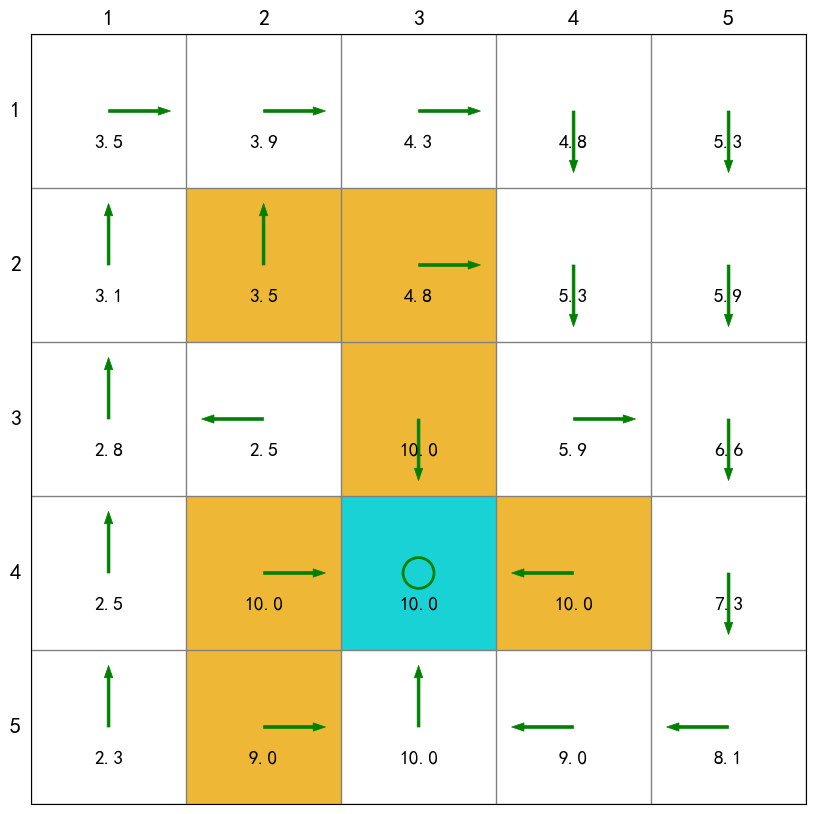

算法耗时: 0.1376 秒, 剩余迭代次数: 903
策略矩阵:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
状态值函数:
[3.48645648 3.13777804 2.82396745 2.54153791 2.28735133 3.87387697
 3.48645648 2.54153791 9.99967208 8.99967208 4.30434418 4.78264108
 9.99967208 9.99967208 9.99967208 4.78264108 5.31408208 5.90457208
 9.99967208 8.99967208 5.31408208 5.90457208 6.56067208 7.28967208
 8.09967208]
演示完成！


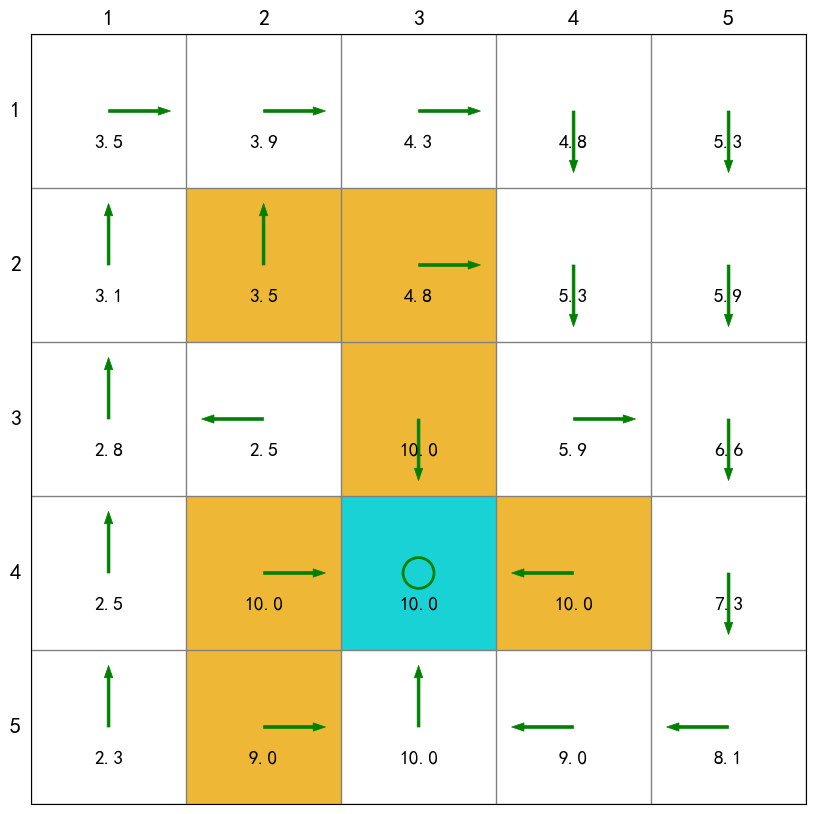

In [12]:
# Step6: 运行示例
print("创建网格世界环境...")
env = GridWorldEnv(
    size=5, 
    start=[0, 0],
    target=[2, 3],
    forbidden=[[1, 1], [2, 1], [2, 2], [1, 3], [1, 4], [3, 3]],
    render_mode='',
    reward_list=[0, 1, -10, -1]  # [普通移动，达到目标，撞到障碍物，撞到边界]
)
# 可视化策略和状态值

print("状态空间信息:", env.get_state_space_info())

# 创建求解器并运行值迭代算法
solver = Solver(env, gamma=0.9)
start_time = time.time()

# 选择要运行的算法
print("运行值迭代算法...")
policy, state_value, remaining_iterations = solver.value_iteration()
end_time = time.time()
cost_time = end_time - start_time
# print("运行策略迭代算法...")
# policy, state_value, remaining_iterations = solver.policy_iteration()
solver.show_policy(policy=solver.policy, render_mode='show')
solver.show_state_value(state_value=solver.state_value, y_offset=0.2, render_mode='show')
print(f"算法耗时: {round(cost_time, 4)} 秒, 剩余迭代次数: {remaining_iterations}")
print("策略矩阵:")
print(policy)
print("状态值函数:")
print(state_value)
print("演示完成！")